<a href="https://colab.research.google.com/github/GrzegorzMeller/AlgorithmsForMassiveData/blob/master/OCULAR_DISEASE_RECOGNITION_N_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/amd/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /amd/


In [0]:
!cp /amd/My\ Drive/ODIR-5K_aug_noclahe.zip /content/

In [0]:
!unzip ODIR-5K.zip

In [4]:
import os
import glob

items_to_remove = []
all_elements_train=0
all_elements_val = 0
for element in glob.glob("ODIR-5K/Training Images/*.jpg"):
  img_name = element.split("/")[-1]
  img_label = img_name.split("-")
  if img_label[1] != "N.jpg" and img_label[1] != "C.jpg":
    items_to_remove.append(element)
  else:
    all_elements_train+=1
  
for element in glob.glob("ODIR-5K/Validation_Images/*.jpg"):
  img_name = element.split("/")[-1]
  img_label = img_name.split("-")
  if img_label[1] != "N.jpg" and img_label[1] != "C.jpg":
    items_to_remove.append(element)
  else: 
    all_elements_val+=1
  
for e in items_to_remove:
  os.remove(e)

print(all_elements_train, all_elements_val)

3567 919


In [0]:
import tensorflow as tf
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
import glob
import random

BATCH_SIZE = 32
IMG_HEIGHT = 250
IMG_WIDTH = 250
CLASS_NAMES = ['N', 'C']

In [0]:
resampled1_ds =  tf.data.Dataset.list_files("ODIR-5K/Training Images/*.jpg")
test_ds = tf.data.Dataset.list_files("ODIR-5K/Validation_Images/*.jpg")

In [0]:
def get_label(name):
  parts = tf.strings.split(name, sep="-")
  label = tf.strings.split(parts[-1], sep=".")
  label = tf.strings.bytes_split(label[0])
  l = [0, 0]

  for e in label:
    if e != '&' and e != 'X':
      if e == 'N':
        l[0] = 1
      elif e == 'C':
        l[1] = 1
  return l

def get_name(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-1]

def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  #img = tf.image.adjust_contrast(img, 2)
  img = tf.image.convert_image_dtype(img, tf.float32)
  #img = tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)
  return img

def process_path(file_path):
  name = get_name(file_path)
  label = get_label(name)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [0]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
resampled_named_ds = resampled1_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_named_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

label:  N [1 0]
label:  C [0 1]
label:  C [0 1]
label:  N [1 0]
label:  N [1 0]
label:  C [0 1]


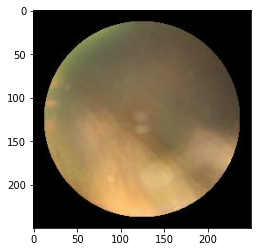

In [10]:
for image, label in resampled_named_ds.take(6):
  plt.imshow(image.numpy())
  print('label: ', CLASS_NAMES[np.nonzero(label.numpy()==1)[0][0]], label.numpy())

In [0]:
def randomly_augment(image,label):
  image = tf.image.random_flip_left_right(image)
  #image = tf.image.central_crop(image, central_fraction=0.9)
  #image = tf.image.resize_with_pad(image, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)
  return image, label

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  #ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=False)
  #ds = ds.map(randomly_augment, num_parallel_calls=AUTOTUNE)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE, drop_remainder=True)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  ds = ds.cache()
  ds = ds.batch(32, drop_remainder=True) #all elemetnts for training should be batched in one!
  ds = ds.repeat()

  return ds

In [0]:
final_train_ds = prepare_for_training(resampled_named_ds,cache=True,shuffle_buffer_size=3000)
final_test_ds = prepare_for_testing(test_named_ds,cache=True,shuffle_buffer_size=100)

[1 0]


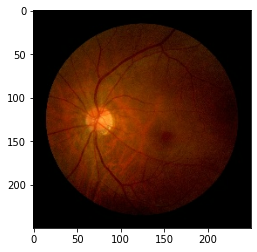

In [13]:
for example in final_train_ds.take(1):
  image, label = example
  break
im, lab = image[13], label[13]
plt.imshow(im.numpy())
print(lab.numpy())

In [14]:
model_cnn = tf.keras.Sequential([
    
    # 1st VGG block
    tf.keras.layers.Conv2D(32, (5, 5), padding = "same", input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(32, (5, 5), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Dropout(0.45),

    #2nd VGG block
    tf.keras.layers.Conv2D(128, (5, 5), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(128, (5, 5), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Dropout(0.45),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(2, activation = 'softmax')
])

model_cnn.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 250, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 250, 250, 32)      96        
_________________________________________________________________
activation (Activation)      (None, 250, 250, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 250, 250, 32)      25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 250, 250, 32)      96        
_________________________________________________________________
activation_1 (Activation)    (None, 250, 250, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 83, 83, 32)        0

In [15]:
history_cnn = model_cnn.fit(final_train_ds,
                    #batch_size=32,
                    epochs=50,
                    steps_per_epoch = 100, #train_elements/batch_size
                    validation_data=final_test_ds,
                    validation_steps = 25,
                    use_multiprocessing=True,
                    #class_weight=class_weight
                    )

Epoch 1/50
100/100 [==============================] - 12s 120ms/step - loss: 1.1626 - accuracy: 0.6919 - val_loss: 1.3594 - val_accuracy: 0.0988
Epoch 2/50
100/100 [==============================] - 15s 145ms/step - loss: 0.5626 - accuracy: 0.8009 - val_loss: 3.1295 - val_accuracy: 0.0988
Epoch 3/50
100/100 [==============================] - 14s 144ms/step - loss: 0.4643 - accuracy: 0.8388 - val_loss: 2.5676 - val_accuracy: 0.0950
Epoch 4/50
100/100 [==============================] - 14s 142ms/step - loss: 0.3420 - accuracy: 0.8700 - val_loss: 2.9392 - val_accuracy: 0.1050
Epoch 5/50
100/100 [==============================] - 14s 140ms/step - loss: 0.3445 - accuracy: 0.8759 - val_loss: 4.3669 - val_accuracy: 0.1175
Epoch 6/50
100/100 [==============================] - 14s 138ms/step - loss: 0.3533 - accuracy: 0.8828 - val_loss: 1.0397 - val_accuracy: 0.6012
Epoch 7/50
100/100 [==============================] - 13s 128ms/step - loss: 0.3436 - accuracy: 0.8825 - val_loss: 1.0130 - val_ac

KeyboardInterrupt: ignored